# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet from MONAI for classification
* Train the model with a PyTorch program
* Evaluate on test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/2d_classification/mednist_tutorial.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.6.0rc1+15.gf3d436a0
Numpy version: 1.20.3
Pytorch version: 1.9.0a0+c3d40fd
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: f3d436a09deefcf905ece2faeec37f55ab030003

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [5]:
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [7]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

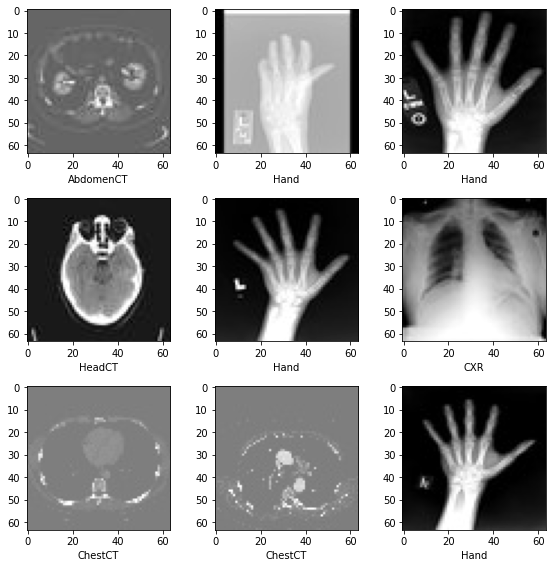

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [9]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47156, Validation count: 5913, Test count: 5885


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [11]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300, num_workers=10)

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.7898
2/157, train_loss: 1.7560
3/157, train_loss: 1.7461
4/157, train_loss: 1.7241
5/157, train_loss: 1.6973
6/157, train_loss: 1.6706
7/157, train_loss: 1.6388
8/157, train_loss: 1.6210
9/157, train_loss: 1.5989
10/157, train_loss: 1.5599
11/157, train_loss: 1.5826
12/157, train_loss: 1.5339
13/157, train_loss: 1.5235
14/157, train_loss: 1.5098
15/157, train_loss: 1.4746
16/157, train_loss: 1.4584
17/157, train_loss: 1.4365
18/157, train_loss: 1.4328
19/157, train_loss: 1.4274
20/157, train_loss: 1.4327
21/157, train_loss: 1.4017
22/157, train_loss: 1.3231
23/157, train_loss: 1.3180
24/157, train_loss: 1.3001
25/157, train_loss: 1.2958
26/157, train_loss: 1.3021
27/157, train_loss: 1.2336
28/157, train_loss: 1.2154
29/157, train_loss: 1.2595
30/157, train_loss: 1.2050
31/157, train_loss: 1.2161
32/157, train_loss: 1.2106
33/157, train_loss: 1.1495
34/157, train_loss: 1.1550
35/157, train_loss: 1.1246
36/157, train_loss: 1.1607
37/157, train_lo

137/157, train_loss: 0.1131
138/157, train_loss: 0.1349
139/157, train_loss: 0.1316
140/157, train_loss: 0.0989
141/157, train_loss: 0.1081
142/157, train_loss: 0.1240
143/157, train_loss: 0.1104
144/157, train_loss: 0.0980
145/157, train_loss: 0.1081
146/157, train_loss: 0.0906
147/157, train_loss: 0.1624
148/157, train_loss: 0.1025
149/157, train_loss: 0.1071
150/157, train_loss: 0.0988
151/157, train_loss: 0.1151
152/157, train_loss: 0.1425
153/157, train_loss: 0.1092
154/157, train_loss: 0.0831
155/157, train_loss: 0.1252
156/157, train_loss: 0.0960
157/157, train_loss: 0.1076
158/157, train_loss: 0.0725
epoch 2 average loss: 0.1612
saved new best metric model
current epoch: 2 current AUC: 0.9997 current accuracy: 0.9863 best AUC: 0.9997 at epoch: 2
----------
epoch 3/4
1/157, train_loss: 0.1095
2/157, train_loss: 0.0810
3/157, train_loss: 0.1085
4/157, train_loss: 0.1033
5/157, train_loss: 0.1527
6/157, train_loss: 0.0988
7/157, train_loss: 0.0935
8/157, train_loss: 0.0903
9/157, 

111/157, train_loss: 0.0538
112/157, train_loss: 0.0290
113/157, train_loss: 0.0567
114/157, train_loss: 0.0455
115/157, train_loss: 0.0502
116/157, train_loss: 0.0338
117/157, train_loss: 0.0541
118/157, train_loss: 0.0496
119/157, train_loss: 0.0461
120/157, train_loss: 0.0353
121/157, train_loss: 0.0569
122/157, train_loss: 0.0282
123/157, train_loss: 0.0299
124/157, train_loss: 0.0366
125/157, train_loss: 0.0397
126/157, train_loss: 0.0339
127/157, train_loss: 0.0417
128/157, train_loss: 0.0515
129/157, train_loss: 0.0433
130/157, train_loss: 0.0435
131/157, train_loss: 0.0310
132/157, train_loss: 0.0497
133/157, train_loss: 0.0366
134/157, train_loss: 0.0436
135/157, train_loss: 0.0387
136/157, train_loss: 0.0291
137/157, train_loss: 0.0480
138/157, train_loss: 0.0377
139/157, train_loss: 0.0346
140/157, train_loss: 0.0265
141/157, train_loss: 0.0497
142/157, train_loss: 0.0352
143/157, train_loss: 0.0264
144/157, train_loss: 0.0349
145/157, train_loss: 0.0409
146/157, train_loss:

## Plot the loss and metric

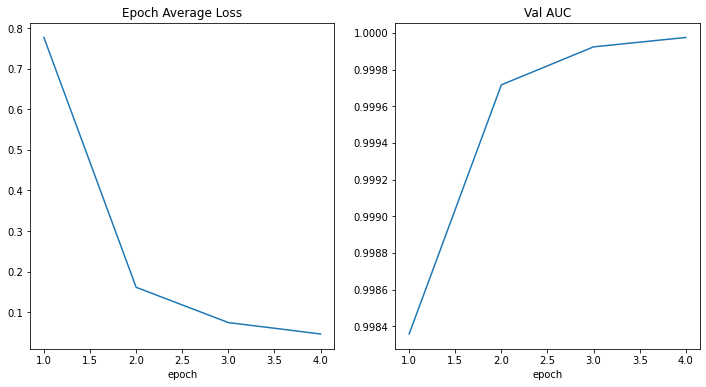

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [15]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [16]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

Note: you may need to restart the kernel to use updated packages.
              precision    recall  f1-score   support

   AbdomenCT     0.9816    0.9917    0.9867       969
   BreastMRI     0.9968    0.9831    0.9899       944
         CXR     0.9979    0.9928    0.9954       973
     ChestCT     0.9938    0.9990    0.9964       959
        Hand     0.9934    0.9934    0.9934      1055
      HeadCT     0.9960    0.9990    0.9975       985

    accuracy                         0.9932      5885
   macro avg     0.9932    0.9932    0.9932      5885
weighted avg     0.9932    0.9932    0.9932      5885



## Cleanup data directory

Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)